# Introduction

This notebook builds a MLP neural net from simulation data, and then transpiles it to HLS. This can then be imported by M3602A/PathWave, and synthesized and deployed on an FPGA. This is the full pipeline, with simulation providing the training data for the neural net. `experiment_pipeline.ipynb` contains similar code, except it trains the network on experimental data.

# Qubit-Resonator Simulation

In [1]:
!pip install qutip

import matplotlib.pyplot as plt
import numpy as np
import qutip, defs, helpers_qutip, os

# QuTip Settings
qutip.settings.num_cpus = 4

# Helper Functions
def extract_expect_op_trajectory(result_sme, expect_op):
    return np.array( [qutip.expect(expect_op, _rho) for _rho in result_sme.states] )    

def plot_trajectories(time, trajectories, ylabel = '$<\sigma_z>$'):
    fig, ax = plt.subplots(figsize=(6,4))
    for trajectory in trajectories:
        ax.plot(time, trajectory)
        ax.set_ylim([-1, 1])
        ax.set_xlabel('Time ($\mu$s)')
        ax.set_ylabel(ylabel)

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


## Obtain Trajectories (load them if on disk, otherwise recompute them)

In [2]:
# load datasets from disk if they exist, otherwise compute them

path = 'datasets/trajectory_time.npy'
if os.path.exists(path):
    trajectory_time = np.load('datasets/trajectory_time.npy')
    z_plus_sigma_z = np.load('datasets/z_plus_sigma_z.npy')
    z_minus_sigma_z = np.load('datasets/z_minus_sigma_z.npy')
    z_plus_r_t = np.load('datasets/z_plus_r_t.npy')
    z_minus_r_t = np.load('datasets/z_minus_r_t.npy')
    print(f"Loaded trajectories, {z_minus_r_t.shape[0]} trajectories present.")

else:
    os.makedirs('datasets/')
    
    # load QuTip definitions
    p = defs.get_parameters(num_sites=1, num_fock=[5])
    ops = helpers_qutip.Operators(p, swap_tensor_order=True)
    hamiltonian = defs.get_hamiltonian(p, ops)    
    c_ops = defs.get_collapse_operators(p, ops)

    # time-evolution
    state_plus_z  = defs.get_initial_state(p, state_qb='+z_tilde')
    state_minus_z = defs.get_initial_state(p, state_qb='-z_tilde')
    n_traj = 1000

    # trajectories
    result_sme_plus_z = helpers_qutip.solve_time_evolution_trajectories(p,
                                                                        hamiltonian,
                                                                        state_plus_z, 
                                                                        [c_ops[1]],
                                                                        sc_ops=[c_ops[0]],
                                                                        ntraj = n_traj,
                                                                        nsubsteps=p.nsubsteps)

    result_sme_minus_z = helpers_qutip.solve_time_evolution_trajectories(p,
                                                                        hamiltonian,
                                                                        state_minus_z, 
                                                                        [c_ops[1]],
                                                                        sc_ops=[c_ops[0]],
                                                                        ntraj = n_traj,
                                                                        nsubsteps=p.nsubsteps)


    # Extract \sigma_z(t) trajectories from SME solution
    trajectory_time = p.times
    z_plus_sigma_z =  extract_expect_op_trajectory(result_sme_plus_z, ops.Sz[0]) 
    z_minus_sigma_z = extract_expect_op_trajectory(result_sme_minus_z, ops.Sz[0]) 
    np.save('datasets/trajectory_time.npy', trajectory_time)
    np.save('datasets/z_plus_sigma_z.npy',  z_plus_sigma_z)
    np.save('datasets/z_minus_sigma_z.npy', z_minus_sigma_z)

    # Extract r(t) trajectories from SME solution
    z_plus_r_t  = result_sme_plus_z.measurement
    z_minus_r_t = result_sme_minus_z.measurement
    np.save('datasets/z_plus_r_t.npy',  z_plus_r_t)
    np.save('datasets/z_minus_r_t.npy', z_minus_r_t)

Loaded trajectories, 1000 trajectories present.


### r(t) for |0&gt; and |1&gt;

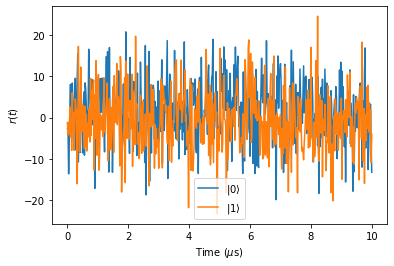

In [3]:
# plot the measurement signal vs timesteps
plt.plot(trajectory_time, np.real(z_plus_r_t[0]),  label = r'$| 0 \rangle $')  
plt.plot(trajectory_time, np.real(z_minus_r_t[1]), label = r'$| 1 \rangle $')  
plt.xlabel('Time ($\mu$s)')
plt.ylabel('$r(t)$')
plt.legend()
plt.savefig('figures/r_t.png')
plt.show()

### Integrated r(t) for |0&gt; and |1&gt;

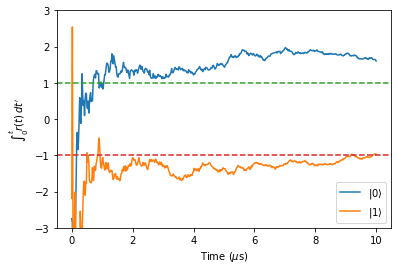

In [4]:
# get integrated "r(t)" for a single trajectory
plt.plot(trajectory_time, np.real(np.cumsum(z_plus_r_t[0])/np.arange(1, len(z_plus_r_t[0])+1)), label = r'$| 0 \rangle $')
plt.plot(trajectory_time, np.real(np.cumsum(z_minus_r_t[3])/np.arange(1, len(z_minus_r_t[3])+1)), label = r'$| 1 \rangle $')
plt.axhline(y= 1.0, color='tab:green', linestyle='dashed')
plt.axhline(y=-1.0, color='tab:red',   linestyle='dashed')
plt.ylim(-3,3)
plt.xlabel('Time ($\mu$s)')
plt.ylabel("$\int_{0}^{t} r(t) \,dt'$")
plt.legend()
plt.savefig('figures/int_r_t.png')
plt.show()

### Plot $ \langle \sigma_z \rangle$  for $|0\rangle$ and $|1 \rangle$

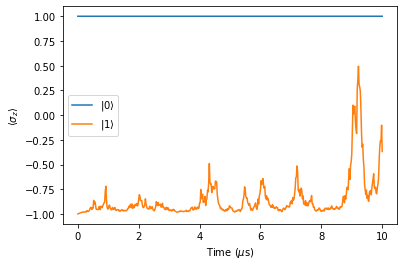

In [5]:
# plot \sigma_z for the same density matrix as above
plt.plot(trajectory_time, np.real(z_plus_sigma_z[0]), label = r'$| 0 \rangle $')
plt.plot(trajectory_time, np.real(z_minus_sigma_z[3]), label = r'$| 1 \rangle $')
plt.xlabel('Time ($\mu$s)')
plt.ylabel(r'$\langle \sigma_z \rangle$')
plt.legend()
plt.savefig('figures/int_r_t.png')
plt.show()

# Classifier Creation

## Averaging (Box-Car) Classifier

/shared-libs/python3.7/py/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/shared-libs/python3.7/py/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


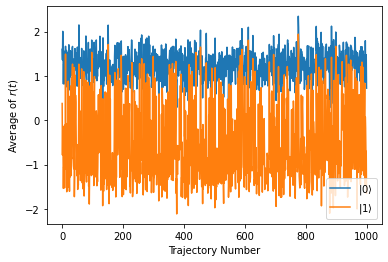

Of 1000 trajectories in |0>, 0 were found to be in |1>.
Of 1000 trajectories in |1>, 296 were found to be in |0>.
This corresponds to a readout fidelity of 0.704


In [6]:
# define classifier
def average_classifier(r_t, start=None, stop=None):
    if start or stop:
        return r_t[:,start:stop].mean(axis=1)
    
    else:
        return r_t.mean(axis=1)

# run classifier
z_plus_r_t = np.array(z_plus_r_t)
z_minus_r_t = np.array(z_minus_r_t)

average_classified_ground = average_classifier(z_plus_r_t)
average_classified_excited = average_classifier(z_minus_r_t)
plt.plot(average_classified_ground, label = r'$| 0 \rangle $')
plt.plot(average_classified_excited, label = r'$| 1 \rangle $')
plt.xlabel("Trajectory Number")
plt.ylabel(r"Average of $r(t)$")
plt.legend()
plt.show()

# find how many trajectories from one state are being found in the other state
print(f'Of {z_plus_r_t.shape[0]} trajectories in |0>, {np.sum(average_classified_ground <= 0)} were found to be in |1>.')
print(f'Of {z_minus_r_t.shape[0]} trajectories in |1>, {np.sum(average_classified_excited >= 0)} were found to be in |0>.')
p_0_1 = np.sum(average_classified_ground <= 0)/z_plus_r_t.shape[0] # frequency of |0> states being found in |1>
p_1_0 = np.sum(average_classified_excited >= 0)/z_minus_r_t.shape[0] # frequency of |1> states being found in |0>

# compute readout fidelity
print(f'This corresponds to a readout fidelity of {round(1 - p_0_1 - p_1_0,4)}')

### Find optimal integration time, by brute force

Optimal Readout Fidelity: 0.869
Optimal Integration Time: 153


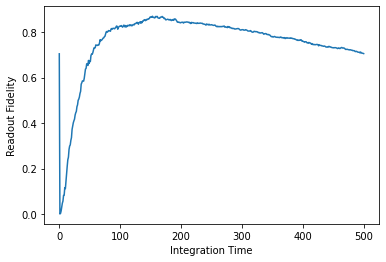

In [7]:
# give averaging classification it's best shot.
# wanna sweep the length of the window to find the one that maximizes readout fidelity
def classify_trajectories(z_plus_r_t, z_minus_r_t, start, stop = None):
    assert z_plus_r_t.shape[0] == z_minus_r_t.shape[0]

    average_classified_ground = average_classifier(z_plus_r_t, start, stop)
    average_classified_excited = average_classifier(z_minus_r_t, start, stop)
    p_0_1 = np.sum(average_classified_ground <= 0)/z_plus_r_t.shape[0] # frequency of |0> states being found in |1>
    p_1_0 = np.sum(average_classified_excited >= 0)/z_minus_r_t.shape[0] # frequency of |1> states being found in |0>
    
    return 1 - p_0_1 - p_1_0


int_lengths = range(z_plus_r_t.shape[1])
fidelities = []
for l in int_lengths:
    fidelities.append(classify_trajectories(z_plus_r_t, z_minus_r_t, 0, l))

fidelities = np.array(fidelities)

print(f"Optimal Readout Fidelity: {max(fidelities)}")
print(f"Optimal Integration Time: {np.argmax(fidelities)}")
plt.plot(fidelities)
plt.xlabel("Integration Time")
plt.ylabel("Readout Fidelity")
plt.show()

## MLP classification (scikit-learn)

### MLP classification on r(t) directly:

In [8]:
# https://scikit-learn.org/stable/modules/neural_networks_supervised.html

from sklearn.neural_network import MLPClassifier
classifier = MLPClassifier(activation='logistic', hidden_layer_sizes=(100,100,100,100),solver='adam', alpha=1e-5, random_state=1, verbose = True)

# only train on 80% of the trajectories, leave the rest for testing
n_train_traj = int(n_traj * 0.8)
n_test_traj = n_traj - n_train_traj

train_z_plus_r_t = np.real(z_plus_r_t[:n_train_traj,:,0])
train_z_minus_r_t = np.real(z_minus_r_t[:n_train_traj,:,0])

test_z_plus_r_t = np.real(z_minus_r_t[n_train_traj:,:,0])
test_z_minus_r_t = np.real(z_minus_r_t[n_train_traj:,:,0])


X = np.vstack((train_z_plus_r_t, train_z_minus_r_t))
Y = np.concatenate((np.ones(n_train_traj), -np.ones(n_train_traj)))

classifier.fit(X,Y);

NameError: name 'n_traj' is not defined

Evaluate performance

In [ ]:
print(f"The classifier's score on the training data is {classifier.score(X, Y)}")

# run classifier on ~1k test poitns
test_data_result_ground = classifier.predict(test_z_minus_r_t)
test_data_result_excited = classifier.predict(test_z_plus_r_t)

# compute readout fidelity
p_0_1 = np.sum(test_data_result_ground <= 0)/test_data_result_ground.shape[0] # frequency of |0> states being found in |1>
p_1_0 = np.sum(test_data_result_excited >= 0)/test_data_result_excited.shape[0] # frequency of |1> states being found in |0>

print(f"A |0> qubit has a probability of {round(p_0_1,3)} of being found in |1>, and a |1> qubit has a probability of {round(p_1_0, 3)} of being found in |0>")
print(f"This is a readout fidelity of {round(1 - p_0_1 - p_1_0, 3)}")

The classifier's score on the training data is 0.995
A |0> qubit has a probability of 0.88 of being found in |1>, and a |1> qubit has a probability of 0.12 of being found in |0>
This is a readout fidelity of 0.0


### MLP Classification on cumulative integral of r(t)

In [ ]:
# evaluate cumulative integral on the truncated r_t curves for the ground and excited states
def integrate_row(row):
    return np.real(np.cumsum(row)/np.arange(1, len(row)+1))

def integrate(x):
    return np.apply_along_axis(integrate_row, 1, x)

classifier = MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 100),solver='adam', alpha=1e-5, random_state=1, verbose = True)
X = np.vstack((integrate(train_z_plus_r_t), integrate(train_z_minus_r_t)))
Y = np.concatenate((-np.ones(n_train_traj), np.ones(n_train_traj)))

classifier.fit(X,Y);

Iteration 1, loss = 0.57247217
Iteration 2, loss = 0.37767510
Iteration 3, loss = 0.27662136
Iteration 4, loss = 0.22094568
Iteration 5, loss = 0.19290670
Iteration 6, loss = 0.17583239
Iteration 7, loss = 0.16744216
Iteration 8, loss = 0.16270805
Iteration 9, loss = 0.15812456
Iteration 10, loss = 0.15484608
Iteration 11, loss = 0.15231299
Iteration 12, loss = 0.14974417
Iteration 13, loss = 0.14790415
Iteration 14, loss = 0.14618605
Iteration 15, loss = 0.14466733
Iteration 16, loss = 0.14332513
Iteration 17, loss = 0.14278348
Iteration 18, loss = 0.14147357
Iteration 19, loss = 0.14011963
Iteration 20, loss = 0.13914576
Iteration 21, loss = 0.13828984
Iteration 22, loss = 0.13742889
Iteration 23, loss = 0.13691088
Iteration 24, loss = 0.13604936
Iteration 25, loss = 0.13600937
Iteration 26, loss = 0.13450863
Iteration 27, loss = 0.13442362
Iteration 28, loss = 0.13390018
Iteration 29, loss = 0.13399025
Iteration 30, loss = 0.13281875
Iteration 31, loss = 0.13098911
Iteration 32, los

In [ ]:
print(f"The classifier's score on the training data is {classifier.score(X, Y)}")

# run classifier on ~1k test poitns
test_data_result_ground = classifier.predict(integrate(test_z_plus_r_t))
test_data_result_excited = classifier.predict(integrate(test_z_minus_r_t))

# compute readout fidelity
p_0_1 = np.sum(test_data_result_ground <= 0)/test_data_result_ground.shape[0] # frequency of |0> states being found in |1>
p_1_0 = np.sum(test_data_result_excited >= 0)/test_data_result_excited.shape[0] # frequency of |1> states being found in |0>

print(f"A |0> qubit has a probability of {round(p_0_1,3)} of being found in |1>, and a |1> qubit has a probability of {round(p_1_0, 3)} of being found in |0>")
print(f"This is a readout fidelity of {round(1 - p_0_1 - p_1_0, 3)}")

The classifier's score on the training data is 0.995
A |0> qubit has a probability of 0.1 of being found in |1>, and a |1> qubit has a probability of 0.9 of being found in |0>
This is a readout fidelity of 0.0


## MLP classification (TensorFlow)

11501568/11490434 [==============================] - 0s 0us/step
Feature matrix: (60000, 28, 28)
Target matrix: (10000, 28, 28)
Feature matrix: (60000,)
Target matrix: (10000,)


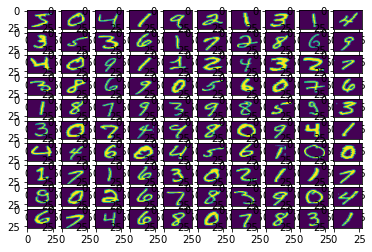

Epoch 1/10
24/24 [==============================] - 3s 116ms/step - loss: 2.0794 - accuracy: 0.4010 - val_loss: 1.7236 - val_accuracy: 0.6330
Epoch 2/10
24/24 [==============================] - 3s 109ms/step - loss: 1.3914 - accuracy: 0.7370 - val_loss: 1.0362 - val_accuracy: 0.8207
Epoch 3/10
24/24 [==============================] - 3s 108ms/step - loss: 0.8660 - accuracy: 0.8223 - val_loss: 0.6706 - val_accuracy: 0.8627
Epoch 4/10
24/24 [==============================] - 3s 105ms/step - loss: 0.6062 - accuracy: 0.8642 - val_loss: 0.4973 - val_accuracy: 0.8892
Epoch 5/10
24/24 [==============================] - 3s 108ms/step - loss: 0.4753 - accuracy: 0.8853 - val_loss: 0.4075 - val_accuracy: 0.8996
Epoch 6/10
24/24 [==============================] - 3s 107ms/step - loss: 0.4028 - accuracy: 0.8972 - val_loss: 0.3566 - val_accuracy: 0.9072
Epoch 7/10
24/24 [==============================] - 3s 106ms/step - loss: 0.3575 - accuracy: 0.9051 - val_loss: 0.3221 - val_accuracy: 0.9135
Epoch 

In [ ]:
# https://www.geeksforgeeks.org/multi-layer-perceptron-learning-in-tensorflow/
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Cast the records into float values
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
  
# normalize image pixel values by dividing 
# by 255
gray_scale = 255
x_train /= gray_scale
x_test /= gray_scale

print("Feature matrix:", x_train.shape)
print("Target matrix:", x_test.shape)
print("Feature matrix:", y_train.shape)
print("Target matrix:", y_test.shape)

fig, ax = plt.subplots(10, 10)
k = 0
for i in range(10):
    for j in range(10):
        ax[i][j].imshow(x_train[k].reshape(28, 28), 
                        aspect='auto')
        k += 1
plt.show()


model = Sequential([
    
    # reshape 28 row * 28 column data to 28*28 rows
    Flatten(input_shape=(28, 28)),
    
      # dense layer 1
    Dense(256, activation='sigmoid'),  
    
    # dense layer 2
    Dense(128, activation='sigmoid'), 
    
      # output layer
    Dense(10, activation='sigmoid'),  
])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



model.fit(x_train, y_train, epochs=10, 
          batch_size=2000, 
          validation_split=0.2)


results = model.evaluate(x_test,  y_test, verbose = 0)
print('test loss, test acc:', results)

# HLS Transpilation with HLS4ML

In [ ]:
!pip install hls4ml
import hls4ml
config = hls4ml.utils.config_from_keras_model(model, granularity='model')
print("-----------------------------------")
print("Configuration")
#plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir='MLP_model/hls4ml_prj',
                                                       part='xcu250-figd2104-2L-e')

hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)
hls_model.compile()
X_test = np.ascontiguousarray(X_test)
y_hls = hls_model.predict(X_test)

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
Interpreting Sequential
Topology:
Layer name: flatten_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (sigmoid), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (sigmoid), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (sigmoid), layer name: dense_2
-----------------------------------
Configuration
-----------------------------------
Interpreting Sequential
Topology:
Layer name: flatten_input, layer type: InputLayer, input shapes: [[None, 28, 28]], output shape: [None, 28, 28]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 28, 28]], output shape: [None, 784]
Layer name: dense, layer type: Dense, input shapes: [[None, 784]], output shape: [None, 256]
Layer name: dense_1, layer type: Dense, input shapes: [[None, 256]], output shape: [None, 128]
Layer name: dense_2, layer type: Dense, input s

NameError: name 'X_test' is not defined

In [ ]:
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, le.classes_)
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_hls, le.classes_, linestyle='--')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['keras', 'hls4ml'],
            loc='lower right', frameon=False)
ax.add_artist(leg)

NameError: name 'accuracy_score' is not defined

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0211f19d-54e4-44e5-ab1c-ce7a6a2d44df' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>